Задача
Построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Описание датасета
В данных предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

Описания полей

client_id - идентификатор клиента
education - уровень образования
sex - пол заемщика
age - возраст заемщика
car - флаг наличия автомобиля
car_type - флаг автомобиля иномарки
decline_app_cnt - количество отказанных прошлых заявок
good_work - флаг наличия “хорошей” работы
bki_request_cnt - количество запросов в БКИ
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса
income - доход заемщика
foreign_passport - наличие загранпаспорта
sna - связь заемщика с клиентами банка
first_time - давность наличия информации о заемщике
score_bki - скоринговый балл по данным из БКИ
region_rating - рейтинг региона
app_date - дата подачи заявки
default - флаг дефолта по кредиту

Загрузка и первичная оценка данных

In [2]:
import numpy as np
import pandas as pd
from pandas import Series

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# загружаем датасеты
d_train = pd.read_csv('train.csv')
d_test = pd.read_csv('test.csv')
d_sample = pd.read_csv('sample_submission.csv')

In [4]:
# выводим информацию о типах призанков, о их количестве к каждом датасете
print('*'*10,'d_train','*'*10)
print(d_train.info())
print('*'*10,'d_test','*'*10)
print(d_test.info())
print('*'*10,'d_sample','*'*10)
print(d_sample.info())

********** d_train **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
client_id           73799 non-null int64
app_date            73799 non-null object
education           73492 non-null object
sex                 73799 non-null object
age                 73799 non-null int64
car                 73799 non-null object
car_type            73799 non-null object
decline_app_cnt     73799 non-null int64
good_work           73799 non-null int64
score_bki           73799 non-null float64
bki_request_cnt     73799 non-null int64
region_rating       73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null int64
sna                 73799 non-null int64
first_time          73799 non-null int64
foreign_passport    73799 non-null object
default             73799 non-null int64
dtypes: float64(1), int64(12), object(6)
memory usage: 10.7+ MB
None
*****

In [5]:
# смотрим на данные
print('d_train: ', d_train.shape)
display(d_train.head())
print('d_test: ', d_test.shape)
display(d_test.head())

d_train:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


d_test:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [6]:
# объединяем данные двух датасетов для обработки
data = pd.concat([d_train, d_test],sort=False)

In [7]:
data.shape

(110148, 19)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 19 columns):
client_id           110148 non-null int64
app_date            110148 non-null object
education           109670 non-null object
sex                 110148 non-null object
age                 110148 non-null int64
car                 110148 non-null object
car_type            110148 non-null object
decline_app_cnt     110148 non-null int64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null int64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null int64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null object
default             73799 non-null float64
dtypes: float64(2), int64(11), object(6)
memory usage: 16.8+ MB


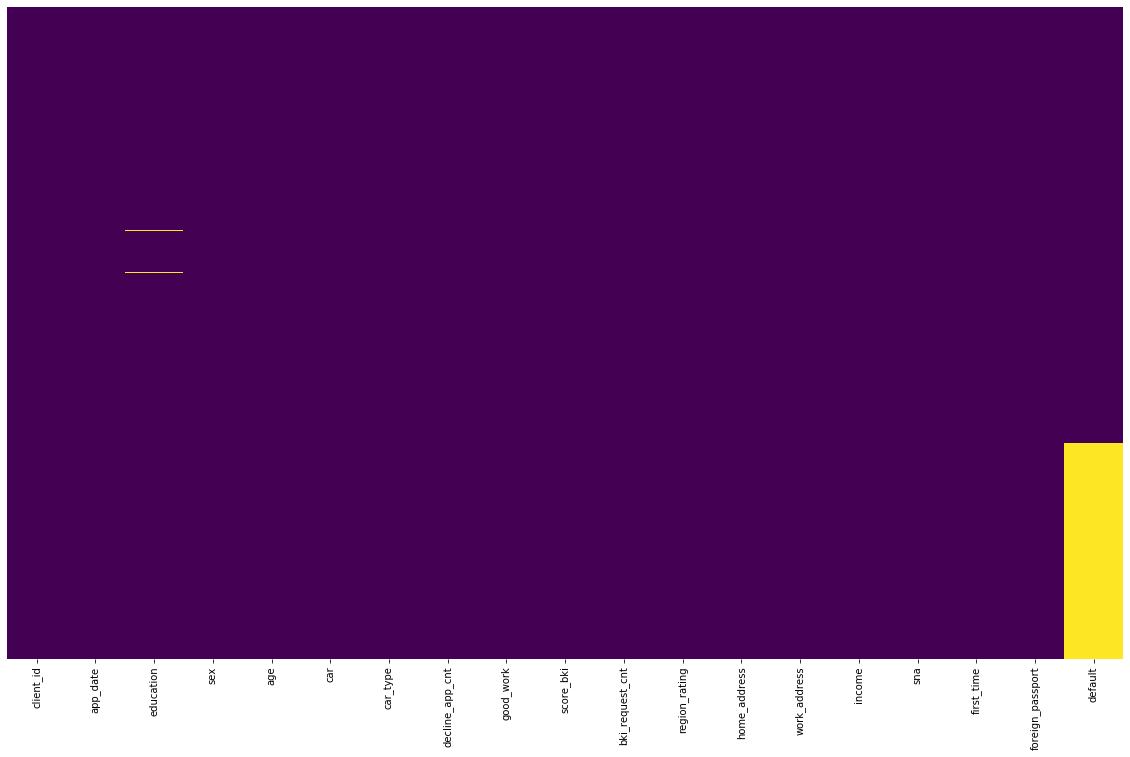

In [9]:
# можно посмотретьна пропуски и таким методом
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Выводы после первичного осмотра данных:

В тренировочной выборке 73799 клиентов.
В тестовой выборке - 36349 клиентов.
Всего 110148 клиентов.
В исходных данных 19 признаков:
1 временной ('app_date'),
6 бинарных ('sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default'),
6 категориальных ('education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time')
6 числовых ('client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income').
Пропуски встречаются только в признаке 'education' - 478 (в train - 307 пропусков, в test - 171 пропуск).
client_id - не стану отбирать для обучения модели.
default - целевая переменная. Есть только в данных train.

Проведём анализ признаков

In [10]:
# выделим признаки в наборы данных по типу: бинарные -с 2мя уникальными значениями, категориальные - где более 2х уникальных значений,
# и числовые
bin_cols = [] 
cat_cols = [] 
num_cols = [] 

In [11]:
def visualizing_number(column):
    bins = 100
    if column.nunique() < 100:
        bins = column.nunique()
    column.hist(bins = bins)
    plt.show()
    sns.boxplot(x='default',y = column,data=data)
    plt.show()
    

In [12]:
def outliers(column):  # подсчет количества выбросов
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    min_out = Q1 - 1.5 * IQR
    max_out = Q3 + 1.5 * IQR
    return (column < min_out).sum() + (column > max_out).sum(), min_out, max_out

проведём работу с временным признком app_date, т.к. в данном виде для анализа не подходит. Выделим из него год, месяц, день, день недели, сезон (зима, весна, лето, осень)

In [13]:
data['app_date'] = pd.to_datetime(data.app_date)
data['app_date_year'] = data.app_date.dt.year
data['app_date_month'] = data.app_date.dt.month
data['app_date_day'] = data.app_date.dt.day
data['app_date_weekday'] = data.app_date.dt.weekday
data['app_date_season'] = data.app_date_month.apply(lambda x: 1 if x in [12,1,2] else 2 if x in [3,4,5] else 3 if x in [6,7,8] else 4)
data = data.drop('app_date',axis=1)

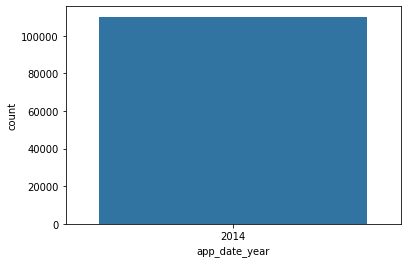

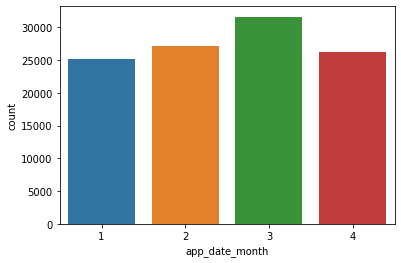

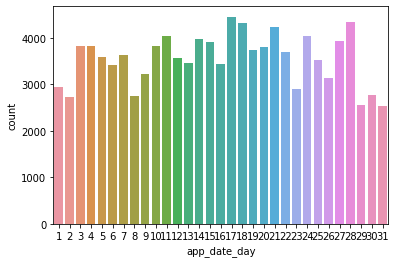

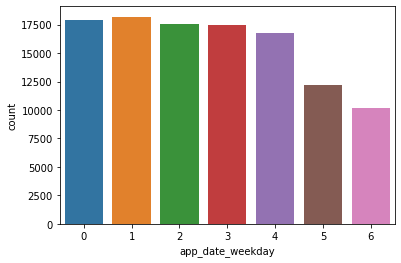

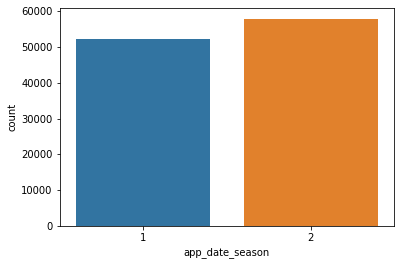

In [14]:
import seaborn as sns
for i in data.iloc[:,18:].columns:
    sns.countplot(x = data[i], data = data)
    plt.show()

In [15]:
# определим временные признки как числовые, исключив год, т.к. не несёт информации для анализа
for i in data.iloc[:,19:].columns:
    num_cols.append(i)
data = data.drop('app_date_year',axis=1)

Исследуем и преобразуем категориальный признак 'education'- образование, содержащий пропуски.

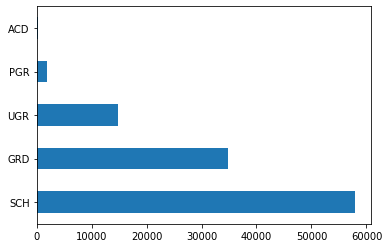

In [16]:
# посмотрим на значения 'education'
data.education.value_counts().plot.barh()
plt.show()

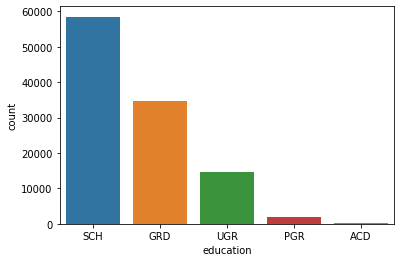

In [17]:
# предыдущая диагармма не показала пропуски.
# Заполним пропуски новой категорией (самым многочисленной) и посмотрим на распределение данных.
data['education'] = data['education'].fillna('SCH')
sns.countplot(x = data['education'], data = data)

In [18]:
# запишем признак 'education' в категориальный набор данных
cat_cols.append('education')

Исследуем и преобразуем бинарный признак 'sex'- пол заёмщика.

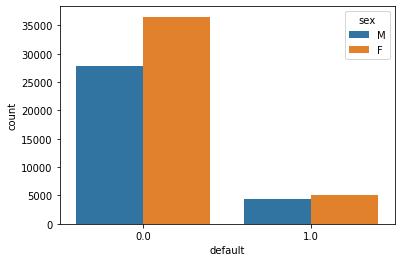

In [19]:
# распределение относительно целевого признака
sns.countplot(x= data['default'],hue = data['sex'], data = data)

Заёмщиков, которые возвращали кредит, больше. Женщин больше как в группе заёмщиком с дефолтом, так и в группе без дефолта.

In [20]:
# запишем признак 'sex' в бинарный набор данных
bin_cols.append('sex')

Исследуем признак age - возраст заёмщика.

0


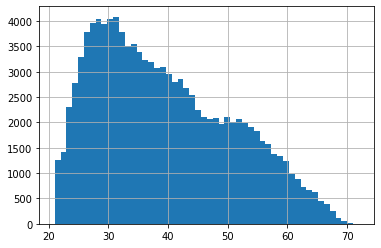

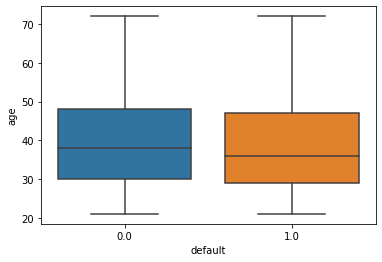

In [21]:
# визуализация для просмотра выбросов
print(outliers(data.age)[0])
visualizing_number(data.age)

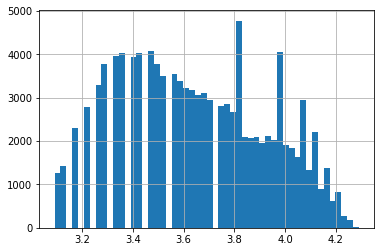

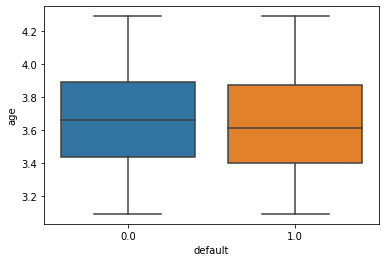

In [22]:
# и применение логарифма
visualizing_number(np.log(data.age + 1))

Выбросов в признаке 'age' не наблюдаем.

In [23]:
# запишем признак 'age' в числовой набор данных
num_cols.append('age')

Исследуем признаки 'car' - флаг наличия автомобиля и 'car type' - флаг автомобиля марки.
Пропучки отсутствуют. Призаки бинарные, т.к. имеют по 2 значения.

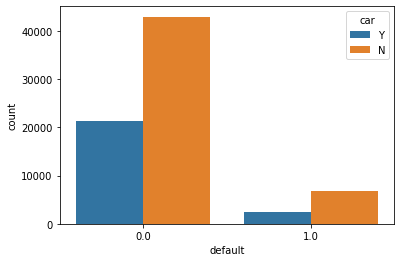

In [24]:
# рассмотрим распределение относительно целевого признака
sns.countplot(x = data['default'], hue= data['car'], data = data)

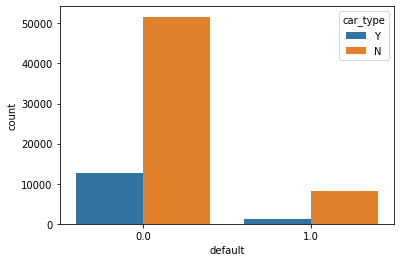

In [25]:
sns.countplot(x = data['default'], hue= data['car_type'], data = data)

Недефолтные клиенты чаще всего имеют автомобиль, и этот автомобиль не является иномаркой.

In [26]:
# отнесём признаки 'car' и 'car_type' к бинарному набору данных
bin_cols.append('car')
bin_cols.append('car_type')

Исследуем признак decline_app_cnt - количество отказанных прошлых заявок.

18677


0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

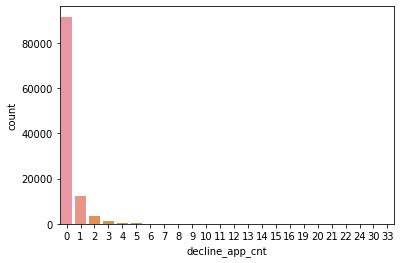

In [27]:
print(outliers(data.decline_app_cnt)[0])
sns.countplot(x = 'decline_app_cnt', data = data)
data.decline_app_cnt.value_counts()

In [28]:
# определим количество и долю выбросов
outs, min_out, max_out = outliers(data['decline_app_cnt'])
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))

Всего выбросов: 18677 
Доля выбросов: 16.95627700911501


Выделим несколько групп: те, кто повторно подавал заявку 0 раз, 1, 2 и 3 или более раз. 
Преобразуем признак из числового к категориальному.

In [29]:
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: x if x < 3 else 3)
data.decline_app_cnt.value_counts()
cat_cols.append('decline_app_cnt')

Исследуем признак good_work - флаг наличия “хорошей” работы.

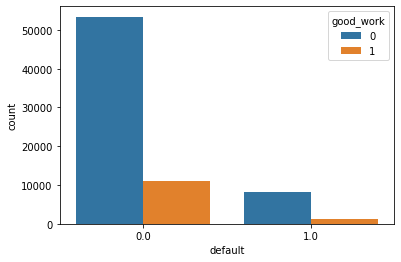

In [30]:
# распределение признака относительно целевого
sns.countplot(x = data['default'], hue= data['good_work'], data = data)

Хорошая работа у меньшей доли исследуемой аудитории. У клиентов с дефолтом, как правило нет хорошей работы. Признак бинарный. Без выбросов.

In [31]:
# определяем в набор бинарных признаков
bin_cols.append('good_work')

In [32]:
# определим количество и долю выбросов
outs, min_out, max_out = outliers(data['score_bki'])
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))

Всего выбросов: 518 
Доля выбросов: 0.47027635544903224


In [33]:
# исключаем выбросы
data = data[((data.default.isna() == False) & (data['score_bki'].between(min_out, max_out))) | data.default.isna() == True]

In [34]:
# определяем в набор числовых признаков
num_cols.append('score_bki')

Исследуем признак bki_request_cnt - количество запросов в БКИ

In [35]:
# определим количество и долю выбросов
outs, min_out, max_out = outliers(data['bki_request_cnt'])
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))

Всего выбросов: 2591 
Доля выбросов: 2.3595730730001456


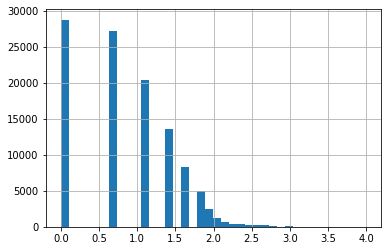

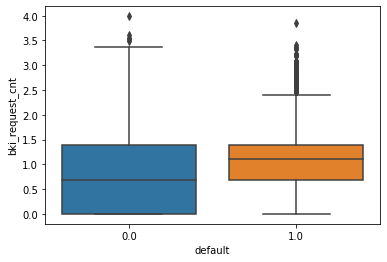

Всего выбросов: 12 
Доля выбросов: 0.01092816552528049


In [36]:
# применим метод логарифмирования (т.к. выбросов немного)
visualizing_number(np.log(data['bki_request_cnt'] + 1))
outs, min_out, max_out = outliers(np.log(data['bki_request_cnt'] + 1))
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))

In [37]:
# логарифмирование
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)
data = data[((data.default.isna() == False) & (data['bki_request_cnt'].between(min_out, max_out))) | data.default.isna() == True]

In [38]:
# определяем в набор числовых признаков
num_cols.append('bki_request_cnt')

Исследуем признак region_rating - рейтинг региона

In [39]:
# определим количество и долю выбросов
outs, min_out, max_out = outliers(np.log(data['region_rating'] + 1))
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))

Всего выбросов: 17842 
Доля выбросов: 16.24924864756562


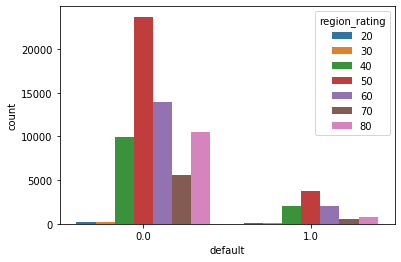

In [40]:
# распределение относительно целевой переменной
sns.countplot(x = data['default'], hue= data['region_rating'], data = data)

In [41]:
data.region_rating.value_counts()

50    40869
60    23935
40    17903
80    17097
70     9253
30      433
20      312
Name: region_rating, dtype: int64

In [42]:
# определяем в набор категориальных признаков
cat_cols.append('region_rating')

Признаки категориальные
home_address - категоризатор домашнего адреса
work_address - категоризатор рабочего адреса

In [43]:
# определяем в набор категориальных признаков
cat_cols.append('home_address')

In [44]:
# определяем в набор категориальных признаков
cat_cols.append('work_address')

Признак income - доход заёмщика

Всего выбросов: 6968 
Доля выбросов: 6.3459681973005955


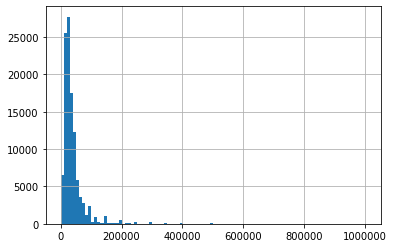

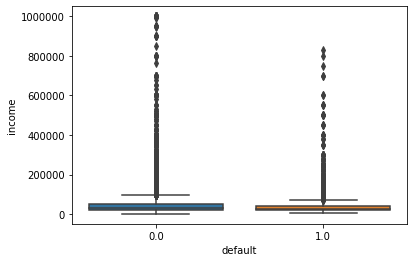

In [45]:
# посмотрим на долю выбросов и распределение
outs, min_out, max_out = outliers(data['income'])
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))
visualizing_number(data.income)

Всего выбросов: 2593 
Доля выбросов: 2.3615234695178593


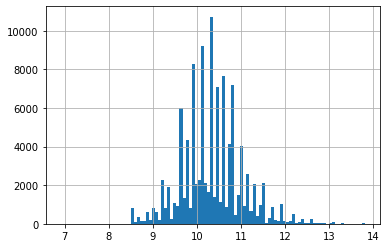

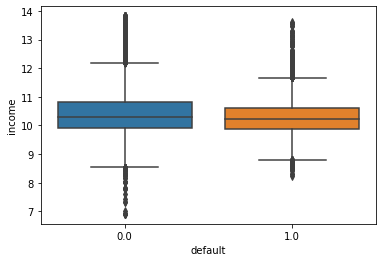

In [46]:
# выбросов много. Логарифмируем и улучшаем распределение.
outs, min_out, max_out = outliers(np.log(data['income'] + 1))
print('Всего выбросов: {} \nДоля выбросов: {}'.format(outs, outs / data.shape[0] *100))
visualizing_number(np.log(data['income'] + 1))

Логарифмирование улучшило распределение.Количество выбросов сократилось до 2%.

In [47]:
# логарифмирование
data['income'] = np.log(data['income'] + 1)

In [48]:
# определяем признак к числовой группе данных
num_cols.append('income')

Категориальные признкаи без пропусков.
sna - связь заемщика с клиентами банка
first_time - давность наличия информации о заемщике

In [49]:
# Определяем к категориальному набору данных
cat_cols.append('sna')
cat_cols.append('first_time')

Признак foreign_passport - наличие загранпаспорта

In [50]:
# Определяем к бинарному набору данных
bin_cols.append('foreign_passport')

Работа с числовыми признакми

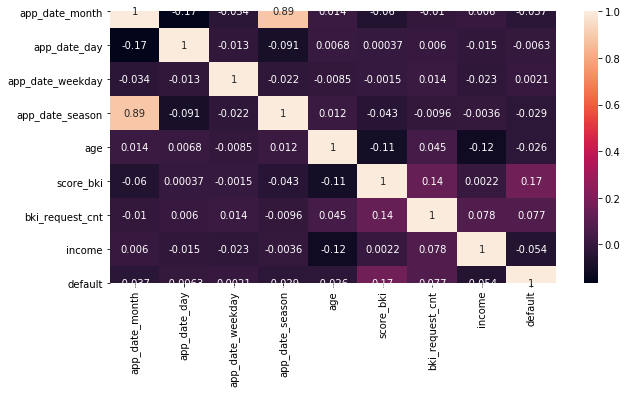

In [51]:
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['default']].corr(), annot=True)

Сильная корреляция между признаками app_date_month и app_date_season. 
Оставляем app_date_month, т.к. он сильнее коррелирует с целевой переменной. app_date_season - удаляем.

In [52]:
# удаление признака
data = data.drop('app_date_season',axis=1)
num_cols.remove('app_date_season')

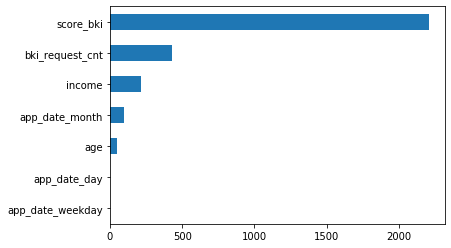

In [53]:
# исследуем значимость числовых признаков
imp_num = Series(f_classif(data[data.default.isna() == False][num_cols], data[data.default.isna() == False]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Наибольший вклад приносит score_bki, остальные признаки менее значимы

Работа с бинарными признаками

In [54]:
# преобразование значений в числа для дальнейшей работы
label_encoder = LabelEncoder()
for i in bin_cols:
    data[i] = label_encoder.fit_transform(data[i])

In [55]:
# смотрим, что получилось
data[bin_cols].head(5)

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1


In [56]:
# подсчитываем количество каждого значения в признаке
for i in bin_cols:
    display(data[i].value_counts())

0    61637
1    48165
Name: sex, dtype: int64

0    74050
1    35752
Name: car, dtype: int64

0    88857
1    20945
Name: car_type, dtype: int64

0    91629
1    18173
Name: good_work, dtype: int64

0    93439
1    16363
Name: foreign_passport, dtype: int64

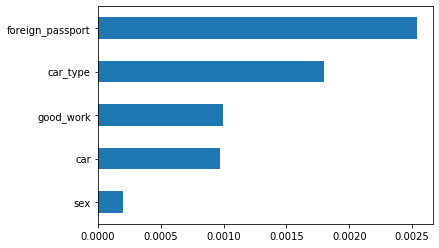

In [57]:
# исследуем значимость бинарных признаков
imp_cat = Series(mutual_info_classif(data[data.default.isna() == False][bin_cols], data[data.default.isna() == False]['default'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самый значимый - foreign_passport. Car_type - тоже важный признак.

Работа с категориальными признаками.

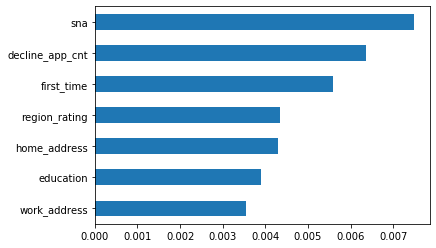

In [58]:
# преобразование значений в числа и исследование значимости признаков
for i in cat_cols:
    label_encoder.fit(data[i])
    data[i] = label_encoder.transform(data[i])
    
imp_cat = Series(mutual_info_classif(data[data.default.isna() == False][cat_cols], data[data.default.isna() == False]['default'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Все бинарные признаки имеют значимость

In [59]:
# преобразование в дамми переменные
data = pd.get_dummies(data, columns = cat_cols)

In [60]:
# просмотр преобразования
data.head(5)

,client_id,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,work_address_1,work_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3
0,25905,1,62,1,1,0,-2.008753,0.693147,9.798183,0,...,1,0,0,0,0,1,1,0,0,0
1,63161,0,59,0,0,0,-1.532276,1.386294,9.852247,0,...,0,1,0,0,0,1,1,0,0,0
2,25887,1,25,1,0,0,-1.408142,0.693147,10.308986,1,...,1,0,1,0,0,0,0,0,0,1
3,16222,0,53,0,0,0,-2.057471,1.098612,9.210440,0,...,0,1,1,0,0,0,0,0,1,0
4,101655,1,48,0,0,1,-1.244723,0.693147,10.308986,1,...,0,1,1,0,0,0,0,0,0,1


ОБУЧЕНИЕ

In [61]:
def count_metrics(y_test, y_pred, y_probs):    
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_probs)  
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    return metrics 

def show_roc_auc(y_test, y_probs):
    fpr, tpr, threshold = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [62]:
# выделение тестовой и тренировочной части
data_train = data[data.default.isna() == False]
data_test = data[data.default.isna() == True]

In [63]:
НАИВНАЯ МОДЕЛЬ

SyntaxError: invalid syntax (<ipython-input-63-0e713375d381>, line 1)

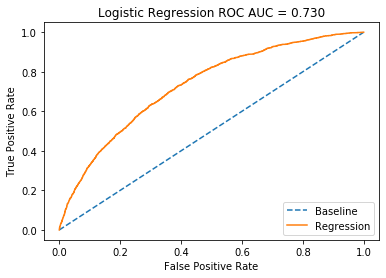

,naive
accuracy,0.873868
f1,0.0482794
roc_auc,0.729721
confusion,"[[12791, 47], [1806, 47]]"


In [64]:
X = data_train.drop(['client_id','default'], axis=1).values
Y = data_train['default'].values

# Делим данные на еще один тест и трейн, для валидации,  
# чтобы проверить, как хорошо модель работает, до отправки submissiona на kaggle.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# обучение модели
model_naive = LogisticRegression(solver = 'liblinear')
model_naive.fit(X_train, y_train)
y_pred = model_naive.predict(X_test)
y_probs = model_naive.predict_proba(X_test)[:,1]

#посмотрю метрики
metrics_naive = count_metrics(y_test, y_pred, y_probs)
data_metrics = pd.DataFrame.from_dict(metrics_naive, orient='index',columns = ['naive'])

show_roc_auc(y_test, y_probs)
display(data_metrics)

Ошибка второго рода, дефолтных клиентов угадывает хуже. 

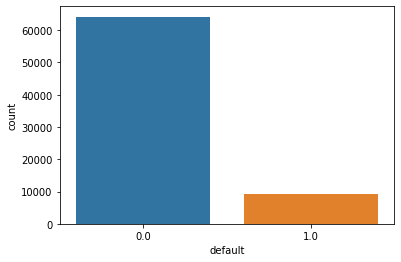

In [65]:
# распределение целевой переменной
sns.countplot(x = data_train['default'], data = data_train)

Распределение целевой переменной несбалансировано. Применим выравнивание количества в дефолтной и недефолтной категориях

МОДЕЛЬ С ПЕРЕОБУЧЕНИЕМ

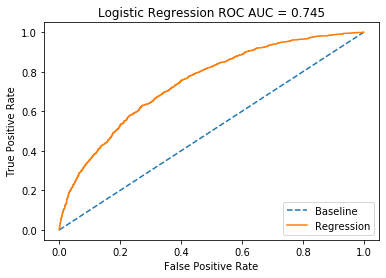

,naive,balanced
accuracy,0.873868,0.675391
f1,0.0482794,0.673009
roc_auc,0.729721,0.744753
confusion,"[[12791, 47], [1806, 47]]","[[1265, 611], [592, 1238]]"


In [66]:
#выравниваем категории
classes = data_train.default.value_counts(ascending=True)
minor = data_train[data_train.default == classes.index[0]]
other = data_train[data_train.default.isin(classes.index[1:])][:classes.iloc[0]]
data_train_balanced = pd.concat([other, minor])

X = data_train_balanced.drop(['client_id','default'], axis=1).values
Y = data_train_balanced['default'].values

# Делим данные на еще один тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#само обучение
model_balanced = LogisticRegression(solver = 'liblinear')
model_balanced.fit(X_train, y_train)
y_pred = model_balanced.predict(X_test)
y_probs = model_balanced.predict_proba(X_test)[:,1]

#смотрим метрики
metrics_balanced = count_metrics(y_test, y_pred, y_probs)
data_metrics['balanced'] = pd.Series(metrics_balanced)

show_roc_auc(y_test, y_probs)
display(data_metrics)

По confusion matrix видим, что теперь модель угадывает и дефотных и недефолтных равномерно. 
Попробуем улучшить метрики, используя нормализацию числовых признаков, т.к. там был разный масштаб

МОДЕЛЬ С НОРМАЛИЗАЦИЕЙ И ПЕРЕОБУЧЕНИЕМ

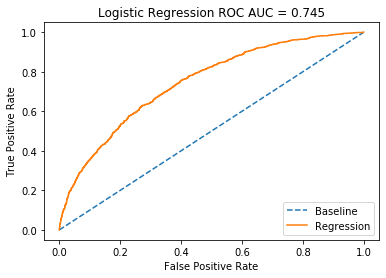

,naive,balanced,std_balanced
accuracy,0.873868,0.675391,0.675391
f1,0.0482794,0.673009,0.673009
roc_auc,0.729721,0.744753,0.744883
confusion,"[[12791, 47], [1806, 47]]","[[1265, 611], [592, 1238]]","[[1265, 611], [592, 1238]]"


In [67]:
#нормализация
num_cols_std = StandardScaler().fit_transform(data_train_balanced[num_cols].values)

X = np.hstack([data_train_balanced.drop(num_cols + ['client_id','default'], axis=1), num_cols_std])
Y = data_train_balanced['default'].values

# Делим данные на еще один тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# обучение модели
model_std_balanced = LogisticRegression(solver = 'liblinear')
model_std_balanced.fit(X_train, y_train)
y_pred = model_std_balanced.predict(X_test)
y_probs = model_std_balanced.predict_proba(X_test)[:,1]

#смотрим метрики
metrics_std_balanced = count_metrics(y_test, y_pred, y_probs)
data_metrics['std_balanced'] = pd.Series(metrics_std_balanced)

show_roc_auc(y_test, y_probs)
display(data_metrics)

МОДЕЛЬ С НОРМАЛИЗАЦИЕЙ И ПЕРЕОБУЧЕНИЕМ. ПОДБОР ГИПЕРПАРАМЕТРОВ.

In [68]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1','l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l1
Лучшее C: 10000.0


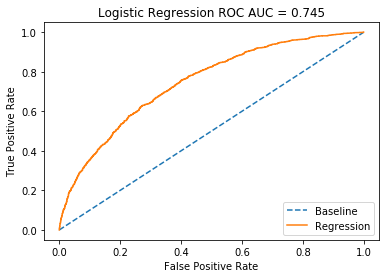

,naive,balanced,std_balanced,finish
accuracy,0.873868,0.675391,0.675391,0.675391
f1,0.0482794,0.673009,0.673009,0.673009
roc_auc,0.729721,0.744753,0.744883,0.74481
confusion,"[[12791, 47], [1806, 47]]","[[1265, 611], [592, 1238]]","[[1265, 611], [592, 1238]]","[[1265, 611], [592, 1238]]"


In [69]:
#обучаем модель с подобранными параметрами
model_finish = LogisticRegression(penalty='l1', C=59.94842503189409, max_iter=1000, solver = 'liblinear')
model_finish.fit(X_train, y_train)

y_pred = model_finish.predict(X_test)
y_probs = model_finish.predict_proba(X_test)[:,1]

#смотрим метрики
metrics_finish = count_metrics(y_test, y_pred, y_probs)
data_metrics['finish'] = pd.Series(metrics_finish)

show_roc_auc(y_test, y_probs)
display(data_metrics)

Балансировка категорий дала улучшения для модели. Возможно, необходима дополнительная работа с признаками, чтобы улучшить модель и доработка самого метода обучения.

ПОДГОТОВКА SUBMISSION

In [70]:
data_test.sample(3)

,client_id,sex,age,car,car_type,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,work_address_1,work_address_2,sna_0,sna_1,sna_2,sna_3,first_time_0,first_time_1,first_time_2,first_time_3
30161,42067,1,36,0,0,0,-2.168697,2.197225,10.819798,0,...,1,0,1,0,0,0,0,0,1,0
23944,82833,0,37,0,0,0,-1.873814,0.693147,10.308986,0,...,0,1,0,1,0,0,1,0,0,0
29714,8397,0,63,0,0,0,-1.435888,0.000000,9.998843,0,...,1,0,1,0,0,0,0,0,1,0


In [71]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.sample(3)

,client_id,default
5779,87851,0.546839
9866,40183,0.618611
14476,101189,0.818819


In [72]:
#расчет на тестовых данных
num_cols_std = StandardScaler().fit_transform(data_test[num_cols].values)
X_test = np.hstack([data_test.drop(num_cols + ['client_id','default'], axis=1), num_cols_std])
y_probs = model_finish.predict_proba(X_test)[:,1]
data_test['default'] = y_probs

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [73]:
#проверка 
submission = data_test[['client_id','default']]
submission.to_csv('submission.csv', index=False)
submission.sample(3)

,client_id,default
12117,10407,0.479817
33707,84745,0.060567
30550,63273,0.392319
